In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import pandas as pd
import numpy as np
import torch
import torch_geometric as pyg
from tqdm.auto import *

from deepgd.model import Generator
from deepgd.data import GraphDrawingData
from deepgd.datasets import  RomeDataset
from deepgd.metrics import Stress, Crossings
from deepgd.transformations import Compose, Center, NormalizeRotation, RescaleByStress
import networkx as nx

In [52]:
device = "cpu"
for backend, device_name in {
    torch.backends.mps: "mps",
    torch.cuda: "cuda",
}.items():
    if backend.is_available():
        device = device_name

In [53]:
# GraphDrawingData.set_optional_fields(["edge_pair_metaindex", "face", "rng"])
dataset = RomeDataset(
    index=pd.read_csv("assets/rome_index.txt", header=None)[0],
)
layouts = np.load("assets/layouts/pmds.npy", allow_pickle=True)
params = Generator.Params(
    num_blocks=11,
    block_depth=3,
    block_width=8,
    block_output_dim=16,
    edge_net_depth=2,
    edge_net_width=8,
    edge_attr_dim=2,
    node_attr_dim=16,
)
model = Generator(
    params=params,
).to(device)
criteria = {
    Stress(): 1,
}

transformation = Compose(
    # Center(),
    # NormalizeRotation(),
    RescaleByStress(),
    )


Transform graphs:   0%|          | 0/11531 [00:00<?, ?it/s]

In [78]:
batch_size = 16
train_size = 10000
lr = 0.001
decay = 0.998

In [55]:
optim = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=decay)
model.load_state_dict(torch.load("./egnn_deepgd/bs_32_model_200.pt"))


<All keys matched successfully>

In [65]:
datalist = list(dataset)
for i, data in enumerate(datalist):
    data.pos = torch.tensor(layouts[i]).float()
    data.feats = torch.randn((data.pos.shape[0], 16)).to(device)
print(len(datalist))

11531


In [79]:
train_loader = pyg.loader.DataLoader(datalist[:train_size], batch_size=batch_size, shuffle=True)
val_loader = pyg.loader.DataLoader(datalist[11000:], batch_size=batch_size, shuffle=False)
test_loader = pyg.loader.DataLoader(datalist[10000:11000], batch_size=batch_size, shuffle=False)

In [67]:
print(datalist[14])

GraphDrawingData(G=DiGraph named 'grafo9962.97' with 97 nodes and 248 edges, perm_index=[2, 9312], edge_metaindex=[248], apsp_attr=[9312], perm_weight=[9312], aggr_metaindex=[9312], pos=[97, 2], name='grafo9962.97', n=[1], m=[1], num_nodes=97, feats=[97, 16])


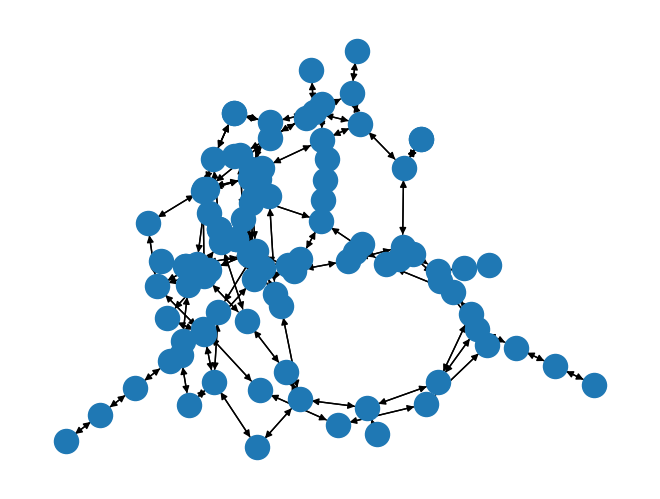

In [68]:
nx.draw(datalist[14].G, datalist[14].pos)

In [69]:
def generate_init_pos(batch):
    # feats = torch.rand_like(batch.pos)
    # feats = torch.ones((batch.pos.shape[0], 16)).to(device)
    feats = torch.randn((batch.pos.shape[0], 16)).to(device)
    feats, pos = generate_init(
        feats=batch.feats,
        pos=batch.pos,
        apsp=batch.apsp_attr,
        edge_index=batch.perm_index,
        batch_index=batch.batch,
    )
    return feats, pos

def get_edge_features(all_pair_shortest_path):
    return torch.cat([
        all_pair_shortest_path[:, None],
        1 / all_pair_shortest_path[:, None].square()
    ], dim=-1)

def generate_init(feats, pos, apsp, edge_index, batch_index):
    return feats, transformation(pos, apsp, edge_index, batch_index)
    

In [70]:
import matplotlib.pyplot as plt
import os
save_dir = 'checkpoint'
def visualization(batch, pos, epoch=0, batch_idx=0):
    pos = pos.detach().cpu()
    count = 0
    for i in range(len(batch)):
        plt.clf()
        pos_dict = {i-count: (pos[i, 0].item(), pos[i, 1].item()) for i in range(pos.shape[0])}
        count += batch[i].G.number_of_nodes()
        nx.draw(batch[i].G, pos=pos_dict, with_labels=True)
        os.makedirs(save_dir, exist_ok=True)
        image_path = os.path.join(save_dir, f"graph_epoch_{epoch}_batch_{batch_idx}_graph_{i}.png")
        plt.savefig(image_path)
        print(f"Graph saved to {image_path}")

def visualization_batch(batch, pos, epoch=0, batch_idx=0, all = False, method = None):
    pos = pos.detach().cpu()
    count = 0
    save_dir = 'visualization'
    for i in range(len(batch)):
        plt.clf()
        pos_dict = {i-count: (pos[i, 0].item(), pos[i, 1].item()) for i in range(pos.shape[0])}
        count += batch[i].G.number_of_nodes()
        nx.draw(batch[i].G, pos=pos_dict, with_labels=True)
        os.makedirs(save_dir, exist_ok=True)
        if method:
            save_dir = os.path.join(save_dir, method)
            os.makedirs(save_dir, exist_ok=True)
        image_path = os.path.join(save_dir, f"graph_epoch_{epoch}_batch_{batch_idx}_graph_{i}.png")
        plt.savefig(image_path)
        print(f"Graph saved to {image_path}")
        if all == False:
            break
            
def download_origin(batch, pos, epoch=0, batch_idx=0):
    pos = pos.detach().cpu()
    pos_dict = {i: (pos[i, 0].item(), pos[i, 1].item()) for i in range(pos.shape[0])}
    pos_path = os.path.join(save_dir, f"pos_epoch_{epoch}_batch_{batch_idx}_origin.txt")
    
    os.makedirs(save_dir, exist_ok=True)
    with open(pos_path, "w") as f:
        for node, position in pos_dict.items():
            f.write(f"{node}: {position}\n")
    print(f"Positions saved to {pos_path}")

def download(batch, pos, epoch=0, batch_idx=0):
    pos = pos.detach().cpu()
    pos_dict = {i: (pos[i, 0].item(), pos[i, 1].item()) for i in range(pos.shape[0])}
    pos_path = os.path.join(save_dir, f"pos_epoch_{epoch}_batch_{batch_idx}.txt")
    
    os.makedirs(save_dir, exist_ok=True)
    with open(pos_path, "w") as f:
        for node, position in pos_dict.items():
            f.write(f"{node}: {position}\n")
    print(f"Positions saved to {pos_path}")

def download_post(batch, pos, epoch=0, batch_idx=0):
    pos = pos.detach().cpu()
    pos_dict = {i: (pos[i, 0].item(), pos[i, 1].item()) for i in range(pos.shape[0])}
    pos_path = os.path.join(save_dir, f"pos_epoch_{epoch}_batch_{batch_idx}_post.txt")
    
    os.makedirs(save_dir, exist_ok=True)
    with open(pos_path, "w") as f:
        for node, position in pos_dict.items():
            f.write(f"{node}: {position}\n")
    print(f"Positions saved to {pos_path}")

# visualization(datalist[0], datalist[0].pos)

In [71]:
# # Hook function to save the output of each layer
# outputs = {}
# def save_output(layer_name):
#     def hook_fn(module, input, output):
#         outputs[layer_name] = output # Detach and move to CPU
#     return hook_fn

# # # Register hooks for all layers
# for name, layer in model.named_modules():
#     layer.register_forward_hook(save_output(name))

In [72]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))
# print(torch.version.cuda)


In [ ]:
max_epoch = 200
for epoch in range(0, max_epoch):
    model.train()
    losses = []
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        batch = batch.to(device)
        model.zero_grad()
        loss = 0
        for c, w in criteria.items():
            node_feats, init_pos = generate_init_pos(batch)
            # download_origin(batch=batch[0], pos=init_pos, epoch=epoch, batch_idx=batch_idx)
            node_feats, pred = model(
                init_pos=init_pos,
                node_feats=node_feats,
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = transformation(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch,  batch.edge_pair_index)
            if loss.isnan():
                break
            ## Test and visualization
            # download(batch=batch[0], pos=pred, epoch=epoch, batch_idx=batch_idx)
            # download_post(batch=batch[0], pos=pos, epoch=epoch, batch_idx=batch_idx)
            # visualization(batch=batch, pos=pred, epoch=epoch, batch_idx=batch_idx)
            # if(epoch % 5 == 0):
                # print(pred)
                # visualization(batch=batch[0], pos=pred, epoch=epoch, batch_idx=batch_idx)
        loss.backward()
        # print("Loss:", loss)
        optim.step()
        losses.append(loss.item())
    scheduler.step()
    if epoch % 20 == 0:
        print(f'[Epoch {epoch}] Train Loss: {np.mean(losses)}')
torch.save(model.state_dict(), f"./egnn_deepgd/bs_32_model_{max_epoch}.pt")

Graph saved to visualization/pmds/graph_epoch_0_batch_0_graph_0.png
Graph saved to visualization/egnn_deepgd/graph_epoch_0_batch_0_graph_0.png
Graph saved to visualization/egnn_deepgd_manual_rotate/graph_epoch_0_batch_0_graph_0.png
Test Loss: nan
Graph saved to visualization/pmds/graph_epoch_0_batch_1_graph_0.png
Graph saved to visualization/egnn_deepgd/graph_epoch_0_batch_1_graph_0.png
Graph saved to visualization/egnn_deepgd_manual_rotate/graph_epoch_0_batch_1_graph_0.png
Test Loss: 318.3587951660156
Graph saved to visualization/pmds/graph_epoch_0_batch_2_graph_0.png
Graph saved to visualization/egnn_deepgd/graph_epoch_0_batch_2_graph_0.png
Graph saved to visualization/egnn_deepgd_manual_rotate/graph_epoch_0_batch_2_graph_0.png
Test Loss: 318.3587951660156
Graph saved to visualization/pmds/graph_epoch_0_batch_3_graph_0.png
Graph saved to visualization/egnn_deepgd/graph_epoch_0_batch_3_graph_0.png
Graph saved to visualization/egnn_deepgd_manual_rotate/graph_epoch_0_batch_3_graph_0.png

StopIteration: 

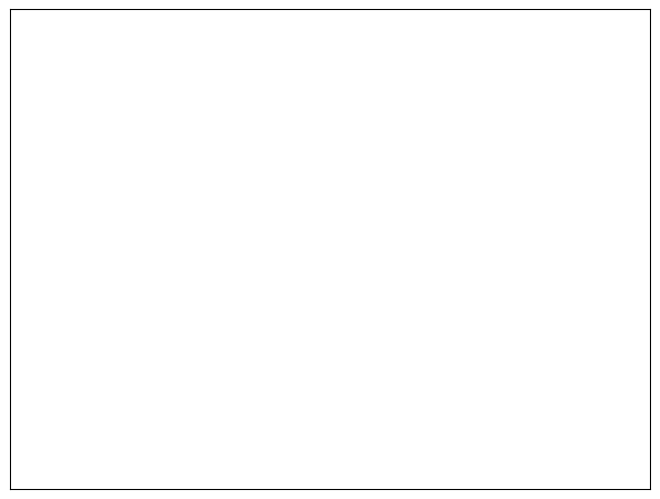

In [91]:
model.load_state_dict(torch.load("./egnn_deepgd/bs_32_model_200.pt"))
with torch.no_grad():
    model.eval()
    losses = []
    for batch_idx, batch in enumerate(tqdm(test_loader, disable=True)):
        batch = batch.to(device)
        loss = 0
        for c, w in criteria.items():
            node_feats, init_pos = generate_init_pos(batch)
            visualization_batch(batch, init_pos, batch_idx = batch_idx, method='pmds')
            node_feats, pred = model(
                init_pos=init_pos,
                node_feats=node_feats,
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = transformation(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            visualization_batch(batch, pos, batch_idx = batch_idx, method='egnn_deepgd')
            pos =  NormalizeRotation(base_angle=1.57)(pos, batch.apsp_attr, batch.perm_index, batch.batch)
            visualization_batch(batch, pos, batch_idx = batch_idx, method='egnn_deepgd_manual_rotate')
            # print(pos)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch,  batch.edge_pair_index)
            print(f'Test Loss: {np.mean(losses)}')
        # break
        if loss.isnan():
            continue
        losses.append(loss.item())
    print(f'final Test Loss: {np.mean(losses)}')

Graph saved to visualization/pmds_after_rotate/graph_epoch_0_batch_0_graph_0.png
Graph saved to visualization/egnn_deepgd_after_rotate/graph_epoch_0_batch_0_graph_0.png
tensor([[-0.5897, -6.4174],
        [-0.3518, -5.3545],
        [-0.0824, -6.5507],
        ...,
        [-0.8067,  1.4600],
        [ 1.9494, -1.9412],
        [ 0.5418, -2.9788]], device='cuda:0')
Test Loss: nan
Graph saved to visualization/pmds_after_rotate/graph_epoch_0_batch_1_graph_0.png
Graph saved to visualization/egnn_deepgd_after_rotate/graph_epoch_0_batch_1_graph_0.png
tensor([[ 0.1725,  1.6982],
        [ 1.3034,  3.3767],
        [-0.6143,  3.0871],
        ...,
        [-0.8068,  1.0705],
        [ 1.6117, -0.2743],
        [-0.3066, -0.1131]], device='cuda:0')
Test Loss: 319.6955871582031
Graph saved to visualization/pmds_after_rotate/graph_epoch_0_batch_2_graph_0.png
Graph saved to visualization/egnn_deepgd_after_rotate/graph_epoch_0_batch_2_graph_0.png
tensor([[-0.9144,  1.2505],
        [ 0.3573,  0.42

StopIteration: 

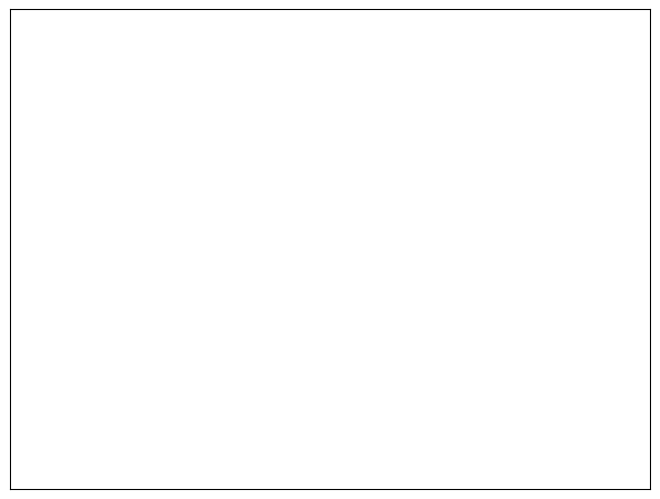

In [93]:
model.load_state_dict(torch.load("./egnn_deepgd/bs_32_model_200.pt"))
with torch.no_grad():
    model.eval()
    losses = []
    for batch_idx, batch in enumerate(tqdm(test_loader, disable=True)):
        batch = batch.to(device)
        loss = 0
        for c, w in criteria.items():
            node_feats, init_pos = generate_init_pos(batch)
            init_pos = NormalizeRotation(base_angle=1.57)(init_pos, batch.apsp_attr, batch.perm_index, batch.batch)
            visualization_batch(batch, init_pos, batch_idx = batch_idx, method='pmds_after_rotate')
            node_feats, pred = model(
                init_pos=init_pos,
                node_feats=node_feats,
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = transformation(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            visualization_batch(batch, pos, batch_idx = batch_idx, method='egnn_deepgd_after_rotate')
            print(pos)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch,  batch.edge_pair_index)
            print(f'Test Loss: {np.mean(losses)}')
        # break
        if loss.isnan():
            continue
        losses.append(loss.item())
    print(f'final Test Loss: {np.mean(losses)}')